In [1]:
# refresh imports
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm import tqdm
import numpy as np
import chess
from stockfish_explain.gen_concepts import create_custom_concepts
import matplotlib.pyplot as plt
import seaborn as sns


# Data Processing

In [ ]:

df = pd.read_csv("/media/ap/storage/stockfish_data/concept_table2.csv")
print(df.shape)

In [7]:
print(df.shape)
# add concept_dict to df
for idx, row in tqdm(df.iterrows()):
    board = chess.Board(row['fen'])
    concept_dict = create_custom_concepts(board)
    for k, v in concept_dict.items():
        df.at[idx, k] = v   
print(df.shape)

columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)
df.to_csv("/media/ap/storage/stockfish_data/concept_table3.csv", index=False)

(90542, 45)


90542it [03:35, 420.16it/s]


(90542, 54)


In [5]:
df.columns.tolist()

['fen',
 'white_bishop_pair',
 'black_bishop_pair',
 'white_knight_pair',
 'black_knight_pair',
 'white_double_pawn',
 'black_double_pawn',
 'white_isolated_pawns',
 'black_isolated_pawns',
 'white_connected_rooks',
 'black_connected_rooks',
 'white_has_control_of_open_file',
 'black_has_control_of_open_file',
 'has_contested_open_file',
 'is_forking',
 'can_fork',
 'can_check',
 'is_checking',
 'white_has_queen',
 'black_has_queen',
 'white_queen_on_first_rank',
 'black_queen_on_first_rank',
 'white_queen_on_initial_square',
 'black_queen_on_initial_square',
 'material_difference',
 'white_has_material_advantage']

In [4]:
import shelve
db_name = 'stockfish_data_04'


sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
keys = list(sh.keys())
print(keys) 
sh.close()

['ckpt_data_last.ckpt']


In [5]:

sh = shelve.open(f"/media/ap/storage/stockfish_data/{db_name}")
data = sh[keys[0]]
print(len(data)) 
sh.close()

4


In [7]:
print(data.keys())
print(len(data['layer1']))
print(data['layer1'][0].shape)
print(data['layer2'][0].shape)
print(data['layer3'][1].shape)
print(data['layer4'][0].shape)

dict_keys(['layer1', 'layer2', 'layer3', 'layer4'])
90542
(2064,)
(8, 16)
(15,)
(8, 32)


In [5]:
len(data['layer1'])

90542

# Concept Model

In [22]:
from stockfish_explain.utils.concepts import (
    evaluate_concepts,
    evaluate_concepts_one,
    classification_cost,

)
from sklearn.neural_network import MLPClassifier, MLPRegressor

# import ridgeregression
from sklearn.linear_model import RidgeClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import r2_score



#model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
models = [
    RidgeClassifier(),
    MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 10), random_state=1, max_iter=1000),
    LGBMClassifier()
]
concepts = [
    'white_bishop_pair',
    #'black_bishop_pair',
    'white_knight_pair',
    #'black_knight_pair',
    'white_double_pawn',
    #'black_double_pawn',
    'white_isolated_pawns',
    #'black_isolated_pawns',
    'white_connected_rooks',
    #'black_connected_rooks',
    'white_has_control_of_open_file',
    #'black_has_control_of_open_file',
    'has_contested_open_file',
    #'is_forking',
    #'can_fork',
    #'can_check',
    #'is_checking',
    'white_has_queen',
    #'black_has_queen',
    'white_queen_on_first_rank',
    #'black_queen_on_first_rank',
    'white_queen_on_initial_square',
    #'black_queen_on_initial_square',
    #'material_difference',
    'white_has_material_advantage'
 ]


metric = classification_cost
db_name = 'stockfish_data_05'

results = []
for concept in concepts:
    for model in models:

        result = evaluate_concepts_one(
            model,
            metric,
            db_name,
            under_sample=True,
            buckets=["all"],
            inspect_layer=[1,2],
            target=concept,
            test_size=0.3,
            num_splits=1,
        )
        results.append(result)

# pickle results with timestamp in string
import pickle
import datetime
file_string = f"results_{datetime.datetime.now()}.pkl"
with open(file_string, "wb") as f:
    pickle.dump(results, f)

print(f'saved file: {file_string}')


  0%|          | 0/1 [00:00<?, ?it/s]07-Dec-22 07:41:41 — root — INFO — starting RidgeClassifier official white_bishop_pair 1 all
07-Dec-22 07:41:42 — root — INFO — X shape: (67650, 2064)
/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.40943e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
07-Dec-22 07:41:43 — root — INFO — score: 0.9857107661985711
07-Dec-22 07:41:43 — root — INFO — starting RidgeClassifier official white_bishop_pair 2 all
07-Dec-22 07:41:44 — root — INFO — X shape: (67650, 144)
07-Dec-22 07:41:44 — root — INFO — score: 0.7522542498152254
  0%|          | 0/1 [00:00<?, ?it/s]07-Dec-22 07:41:44 — root — INFO — starting MLPClassifier official white_bishop_pair 1 all
07-Dec-22 07:41:45 — root — INFO — X shape: (67650, 2064)
07-Dec-22 07:41:48 — root — INFO — Epoch 0 score: 4.927322000503054e-05 (skipping)
07-Dec-22 07:41:52 — root — INFO — Ep

In [18]:
# create list from list of lists results
results = [item for sublist in results for item in sublist]
df = pd.DataFrame(results)
df

,layer,model_name,bucket,target,score,training_size
0,1,RidgeClassifier,all,white_bishop_pair,0.983641,67650
1,2,RidgeClassifier,all,white_bishop_pair,0.752451,67650
2,1,MLPClassifier,all,white_bishop_pair,0.999803,67650
3,2,MLPClassifier,all,white_bishop_pair,0.772752,67650
4,1,LGBMClassifier,all,white_bishop_pair,0.998128,67650
...,...,...,...,...,...,...
61,2,RidgeClassifier,all,white_has_material_advantage,0.354414,44588
62,1,MLPClassifier,all,white_has_material_advantage,0.996412,44588
63,2,MLPClassifier,all,white_has_material_advantage,0.540256,44588
64,1,LGBMClassifier,all,white_has_material_advantage,0.980863,44588


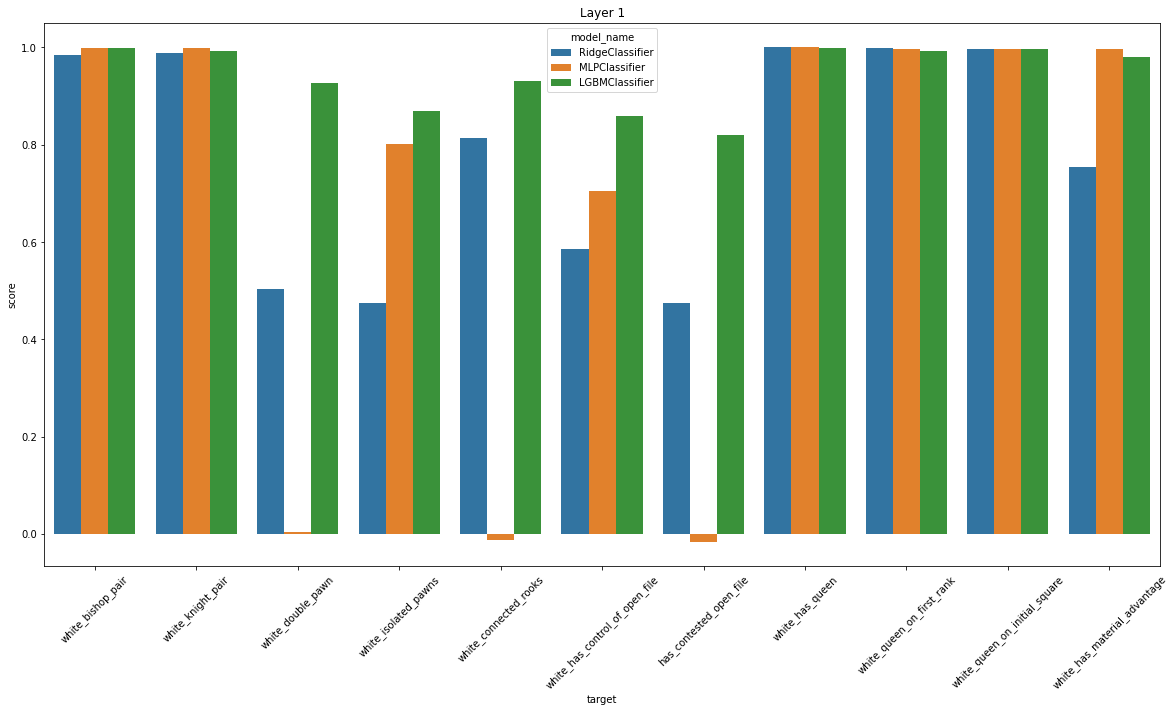

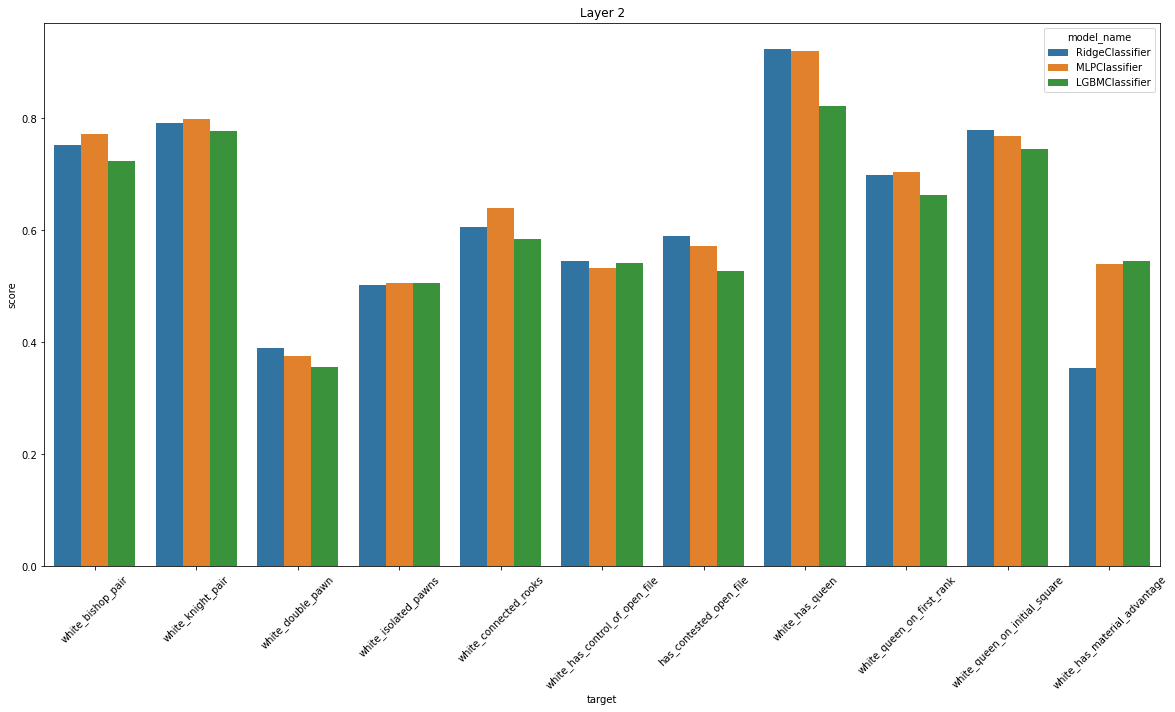

In [19]:
# Create bar plot for each layer
# where x is target, y is score, hue is model_name

# set matplotlib size
plt.rcParams['figure.figsize'] = [20, 10]

for layer in df.layer.unique():
    df_layer = df[df.layer == layer]
    sns.barplot(x='target', y='score', hue='model_name', data=df_layer)
    plt.title(f'Layer {layer}')
    plt.xticks(rotation=45)
    plt.show()

Text(0, 0.5, 'Score')

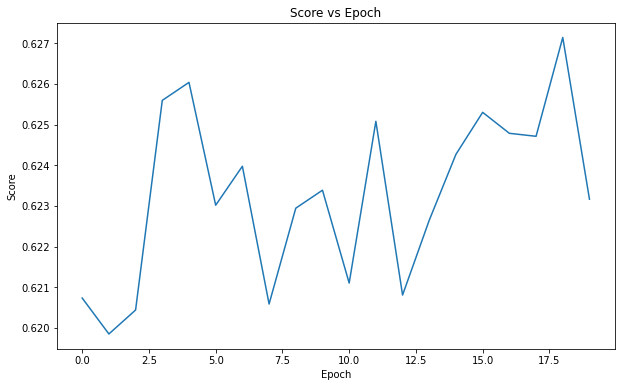

In [3]:
df = pd.DataFrame(results)

# plot score vs epoch

plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='score', data=df)
plt.title('Score vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
